###  Imports

In [1]:
import pickle
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2
import numpy as np

### Get data from Reddit

In [2]:
depressedData = pd.read_csv('./../Data/depressed_posts.csv')
unpopularopinionData = pd.read_csv('./../Data/unpopularopinion_posts.csv')
lonelyData = pd.read_csv('./../Data/lonely_posts.csv')
machinelearningData = pd.read_csv('./../Data/machinelearning_posts.csv')

In [3]:
allPosts = pd.read_csv('./../Data/all_posts.csv')
allPosts.head()

,Author,Subreddit,Date,Title,Post
0,username123456111111,depression,1.620596e+09,i just want to time travel back and fix my mis...,(english is my second language so sorry if i m...
1,iSlurpees,depression,1.620602e+09,Is this depression,"I felt on top of the world Friday night, every..."
2,Awkward-Cat98,depression,1.620643e+09,White hair due to stress and depression,"Hi everyone, \nI really want to hear if anyone..."
3,kitkatpaddywat,depression,1.620593e+09,Everything is “getting back to normal”,And it’s making me super depressed. I have not...
4,sugarpopp,depression,1.620508e+09,Am I happy or am I delusional in my bubble?,"I am 25F, gonna turn 26 on 15th May. have been..."


In [4]:
allPosts.loc[1]['Post']

'I felt on top of the world Friday night, everything was going for me.\nNow I just feel so low and like I’m putting on an act whenever I’m with people.\nI let myself get walked all over and don’t care.\nI keep asking myself who would care if I didn’t come home.\nI drink and don’t stop because it makes me the life of the party for a few hours.\nMakes me not feel small for a while. \nBut then I go back to being alone and the thoughts start coming back.'

### Clean data

In [5]:
print(len(allPosts))

3938


In [6]:
allPosts = allPosts[allPosts['Post'].notna()]
print(len(allPosts))

3809


In [7]:
allPosts['Post'] = allPosts['Post'].astype(str)
print(len(allPosts))

3809


In [8]:
urls = '(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})'
numbers = '\d+(\.\d+)?'
posessivePronouns = '’s'
apostrophe='’'
someSigns ='\\n|\\r'
punctuation = "[^\w\s]" 
whitespaces = '\s+'
leadTrailWhitespace = '^\s+|\s+?$'

allPosts['Post_Parsed'] = allPosts['Post'].str.lower()
allPosts['Post_Parsed'] = allPosts['Post_Parsed'].str.replace(urls,'url',regex=True)
allPosts['Post_Parsed'] = allPosts['Post_Parsed'].str.replace(numbers,'nmbr',regex=True)
allPosts['Post_Parsed'] = allPosts['Post_Parsed'].str.replace(posessivePronouns,'',regex=True)
allPosts['Post_Parsed'] = allPosts['Post_Parsed'].str.replace(apostrophe,'',regex=True)
allPosts['Post_Parsed'] = allPosts['Post_Parsed'].str.replace(someSigns,'',regex=True)
allPosts['Post_Parsed'] = allPosts['Post_Parsed'].str.replace(punctuation,' ',regex=True)
allPosts['Post_Parsed'] = allPosts['Post_Parsed'].str.replace(whitespaces,' ',regex=True)
allPosts['Post_Parsed'] = allPosts['Post_Parsed'].str.replace(leadTrailWhitespace,'',regex=True)

allPosts.loc[1]['Post_Parsed']

'i felt on top of the world friday night everything was going for me now i just feel so low and like im putting on an act whenever im with people i let myself get walked all over and dont care i keep asking myself who would care if i didnt come home i drink and dont stop because it makes me the life of the party for a few hours makes me not feel small for a while but then i go back to being alone and the thoughts start coming back'

In [9]:
allPosts.head()

,Author,Subreddit,Date,Title,Post,Post_Parsed
0,username123456111111,depression,1.620596e+09,i just want to time travel back and fix my mis...,(english is my second language so sorry if i m...,english is my second language so sorry if i ma...
1,iSlurpees,depression,1.620602e+09,Is this depression,"I felt on top of the world Friday night, every...",i felt on top of the world friday night everyt...
2,Awkward-Cat98,depression,1.620643e+09,White hair due to stress and depression,"Hi everyone, \nI really want to hear if anyone...",hi everyone i really want to hear if anyone ha...
3,kitkatpaddywat,depression,1.620593e+09,Everything is “getting back to normal”,And it’s making me super depressed. I have not...,and it making me super depressed i have nothin...
4,sugarpopp,depression,1.620508e+09,Am I happy or am I delusional in my bubble?,"I am 25F, gonna turn 26 on 15th May. have been...",i am nmbrf gonna turn nmbr on nmbrth may have ...


In [10]:
# Downloading punkt and wordnet from NLTK
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\aligo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\aligo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [11]:
# Saving the lemmatizer into an object
wordnet_lemmatizer = WordNetLemmatizer()

In [12]:
nrows = len(allPosts)
lemmatized_text_list = []

for post in allPosts.Post_Parsed:
    
    # Create an empty list containing lemmatized words
    lemmatized_list = []
    
    # Save the text and its words into an object
    text = post
    text_words = text.split(" ")

    # Iterate through every word to lemmatize
    for word in text_words:
        lemmatized_list.append(wordnet_lemmatizer.lemmatize(word, pos="v"))
        
    # Join the list
    lemmatized_text = " ".join(lemmatized_list)
    
    # Append to the list containing the texts
    lemmatized_text_list.append(lemmatized_text)

In [13]:
allPosts['Post_Parsed'] = lemmatized_text_list

In [14]:
allPosts.loc[1]['Post_Parsed']

'i felt on top of the world friday night everything be go for me now i just feel so low and like im put on an act whenever im with people i let myself get walk all over and dont care i keep ask myself who would care if i didnt come home i drink and dont stop because it make me the life of the party for a few hours make me not feel small for a while but then i go back to be alone and the thoughts start come back'

In [15]:
nltk.download('stopwords')
stop_words = list(stopwords.words('english'))

print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aligo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
punctuation = re.compile(r'[^\w\s]')

stop_words_no_punct=[]
for word in stop_words:
    stop_words_no_punct.append(punctuation.sub('', word))
    
print(stop_words_no_punct)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'youre', 'youve', 'youll', 'youd', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'shes', 'her', 'hers', 'herself', 'it', 'its', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'thatll', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', '

In [17]:
from nltk.tokenize import word_tokenize
post_without_stop_words = []

for post in allPosts.Post_Parsed:
    text_tokens = word_tokenize(post)
    tokens_without_stop_words = [word for word in text_tokens if not word in stop_words_no_punct]
    post_without_stop_words.append((" ").join(tokens_without_stop_words))

allPosts['Post_Parsed'] = post_without_stop_words

In [18]:
allPosts.loc[1]['Post_Parsed']

'felt top world friday night everything go feel low like im put act whenever im people let get walk care keep ask would care come home drink stop make life party hours make feel small go back alone thoughts start come back'

### Label Coding

In [19]:
category_codes = {
    'depression': 0,
    'unpopularopinion': 1,
    'lonely': 2,
    'MachineLearning': 3
}

In [20]:
# Category mapping
allPosts['Subreddit_Code'] = allPosts['Subreddit']
allPosts = allPosts.replace({'Subreddit_Code':category_codes})

allPosts.head()

,Author,Subreddit,Date,Title,Post,Post_Parsed,Subreddit_Code
0,username123456111111,depression,1.620596e+09,i just want to time travel back and fix my mis...,(english is my second language so sorry if i m...,english second language sorry make mistake wat...,0
1,iSlurpees,depression,1.620602e+09,Is this depression,"I felt on top of the world Friday night, every...",felt top world friday night everything go feel...,0
2,Awkward-Cat98,depression,1.620643e+09,White hair due to stress and depression,"Hi everyone, \nI really want to hear if anyone...",hi everyone really want hear anyone experience...,0
3,kitkatpaddywat,depression,1.620593e+09,Everything is “getting back to normal”,And it’s making me super depressed. I have not...,make super depress nothing go back job go im s...,0
4,sugarpopp,depression,1.620508e+09,Am I happy or am I delusional in my bubble?,"I am 25F, gonna turn 26 on 15th May. have been...",nmbrf gon na turn nmbr nmbrth may suffer sever...,0


In [21]:
allPosts.to_csv('all_posts_processed.csv', index=False)

### Generating Features

In [22]:
from nltk.tokenize import word_tokenize

def getWordFrequency(processedPostOutputFile):
    posts = pd.read_csv(processedPostOutputFile)

    allPostsConcat = ''
    for post in posts.Post_Parsed:
        if(type(post)==str):
            allPostsConcat+=post

    # create bag-of-words
    all_words = []

    words = word_tokenize(allPostsConcat)
    for word in words:
        all_words.append(word)

    all_words = nltk.FreqDist(all_words)
    
    return all_words

In [23]:
freqWords = getWordFrequency('all_posts_processed.csv')

# print the total number of words and the 100 most common words
print('Number of words: {}'.format(len(freqWords)))
print('Most common words: {}'.format(freqWords.most_common(100)))

word_features = list(freqWords.keys())[:1500]

# save word_features to file
filename = './word_features.data'
pickle.dump(word_features, open(filename, 'wb'))

Number of words: 20781
Most common words: [('nmbr', 4743), ('like', 3595), ('feel', 3009), ('get', 2994), ('people', 2299), ('want', 2247), ('make', 2171), ('know', 2064), ('go', 2047), ('time', 1849), ('think', 1820), ('im', 1819), ('even', 1653), ('one', 1619), ('url', 1492), ('would', 1490), ('life', 1486), ('use', 1389), ('say', 1302), ('really', 1297), ('try', 1233), ('work', 1140), ('friends', 1134), ('talk', 1072), ('see', 1071), ('much', 993), ('someone', 961), ('never', 955), ('model', 955), ('take', 905), ('good', 881), ('need', 874), ('things', 871), ('tell', 871), ('find', 862), ('way', 849), ('day', 832), ('also', 827), ('learn', 822), ('something', 804), ('look', 788), ('start', 787), ('help', 775), ('love', 772), ('live', 765), ('years', 765), ('could', 750), ('still', 737), ('always', 727), ('come', 705), ('better', 686), ('anyone', 664), ('back', 618), ('anything', 616), ('person', 616), ('give', 614), ('point', 611), ('many', 610), ('data', 588), ('lot', 585), ('bad',

[nltk_data] Downloading package webtext to
[nltk_data]     C:\Users\aligo\AppData\Roaming\nltk_data...
[nltk_data]   Package webtext is already up-to-date!


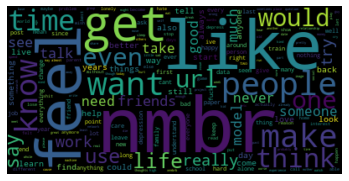

In [24]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
 
nltk.download('webtext')
data_analysis = freqWords
 
filter_words = dict([(m, n) for m, n in data_analysis.items() if len(m) > 2])
 
wcloud = WordCloud().generate_from_frequencies(filter_words)
 
# Plotting the wordcloud
plt.imshow(wcloud, interpolation="bilinear")
 
plt.axis("off")
(-0.5, 399.5, 199.5, -0.5)
plt.show()

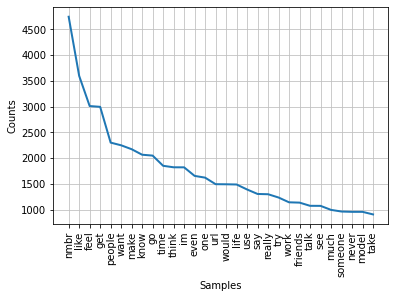

In [25]:
import matplotlib.pyplot as plt
freqWords.plot(30,cumulative=False)
plt.show()

### Train

In [26]:
def find_features(post):
    words = word_tokenize(post)
    features = {}
    for word in word_features:
        features[word] = (word in words)
    return features

In [27]:
posts_all = list(zip(allPosts.loc[:,"Post_Parsed"].values,allPosts.loc[:,"Subreddit_Code"].values))

featuresets = [(find_features(text), label) for (text, label) in posts_all]

from sklearn import model_selection

# split the data into training and testing datasets
seed = 1
training, testing = model_selection.train_test_split(featuresets, test_size = 0.25, random_state=seed)

print(len(allPosts))
print(len(training))
print(len(testing))

# save testing and training data to file
filename = './Models/testing_subreddits.data'
pickle.dump(testing, open(filename, 'wb'))

filename = './Models/training_subreddits.data'
pickle.dump(training, open(filename, 'wb'))

3809
2856
953


### Subreddits Classifier

In [28]:
from nltk.classify.scikitlearn import SklearnClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Define models to train
names = ["K Nearest Neighbors", "Decision Tree", "Random Forest", "Logistic Regression", "SGD Classifier",
         "Naive Bayes", "SVM Linear"]

classifiers = [
    KNeighborsClassifier(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    LogisticRegression(solver='lbfgs', max_iter=1000),
    SGDClassifier(max_iter = 100),
    MultinomialNB(),
    SVC(kernel = 'linear')
]

models = zip(names, classifiers)

for name, model in models:
    nltk_model = SklearnClassifier(model)
    nltk_model.train(training)
    accuracy = nltk.classify.accuracy(nltk_model, testing)*100
    print("{} Accuracy: {}".format(name, accuracy))

K Nearest Neighbors Accuracy: 37.77544596012592
Decision Tree Accuracy: 58.97166841552991
Random Forest Accuracy: 74.92130115424975
Logistic Regression Accuracy: 77.54459601259181
SGD Classifier Accuracy: 74.60650577124869
Naive Bayes Accuracy: 81.74186778593914
SVM Linear Accuracy: 74.92130115424975


In [29]:
# Ensemble methods - Voting classifier
from sklearn.ensemble import VotingClassifier

names = ["K Nearest Neighbors", "Decision Tree", "Random Forest", "Logistic Regression", "SGD Classifier",
         "Naive Bayes", "SVM Linear"]

classifiers = [
    KNeighborsClassifier(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    LogisticRegression(),
    SGDClassifier(max_iter = 100),
    MultinomialNB(),
    SVC(kernel = 'linear')
]

models = list(zip(names, classifiers))

nltk_ensemble = SklearnClassifier(VotingClassifier(estimators = models, voting = 'hard', n_jobs = -1))
nltk_ensemble.train(training)
accuracy = nltk.classify.accuracy(nltk_model, testing)*100
print("Voting Classifier: Accuracy: {}".format(accuracy))

Voting Classifier: Accuracy: 74.92130115424975


In [30]:
# make class label prediction for testing set
txt_features, labels = zip(*testing)

prediction = nltk_ensemble.classify_many(txt_features)

# print a confusion matrix and a classification report
print(classification_report(labels, prediction))

pd.DataFrame(
    confusion_matrix(labels, prediction),
    index = [['actual', 'actual','actual', 'actual'], ['depression', 'unpopularopinion', 'lonely', 'MachineLearning']],
    columns = [['predicted', 'predicted','predicted', 'predicted'], ['depression', 'unpopularopinion', 'lonely', 'MachineLearning']])

              precision    recall  f1-score   support

           0       0.74      0.73      0.74       253
           1       0.84      0.77      0.81       252
           2       0.65      0.77      0.71       229
           3       0.96      0.89      0.92       219

    accuracy                           0.79       953
   macro avg       0.80      0.79      0.79       953
weighted avg       0.80      0.79      0.79       953



predicted                                        
                        depression unpopularopinion lonely MachineLearning
actual depression              185               16     51               1
       unpopularopinion         18              195     33               6
       lonely                   41               11    176               1
       MachineLearning           5               10      9             195

In [31]:
# save the model to disk
filename = './Models/finalized_model_subreddits.sav'
pickle.dump(nltk_ensemble, open(filename, 'wb'))

### r/depression Classifier

In [32]:
category_codes = {
    'depression': 0,
    'unpopularopinion': 1,
    'lonely': 1,
    'MachineLearning': 1
}

# Category mapping
allPosts['Is_Depression_Code'] = allPosts['Subreddit']
allPosts = allPosts.replace({'Is_Depression_Code':category_codes})

allPosts.head()

,Author,Subreddit,Date,Title,Post,Post_Parsed,Subreddit_Code,Is_Depression_Code
0,username123456111111,depression,1.620596e+09,i just want to time travel back and fix my mis...,(english is my second language so sorry if i m...,english second language sorry make mistake wat...,0,0
1,iSlurpees,depression,1.620602e+09,Is this depression,"I felt on top of the world Friday night, every...",felt top world friday night everything go feel...,0,0
2,Awkward-Cat98,depression,1.620643e+09,White hair due to stress and depression,"Hi everyone, \nI really want to hear if anyone...",hi everyone really want hear anyone experience...,0,0
3,kitkatpaddywat,depression,1.620593e+09,Everything is “getting back to normal”,And it’s making me super depressed. I have not...,make super depress nothing go back job go im s...,0,0
4,sugarpopp,depression,1.620508e+09,Am I happy or am I delusional in my bubble?,"I am 25F, gonna turn 26 on 15th May. have been...",nmbrf gon na turn nmbr nmbrth may suffer sever...,0,0


In [33]:
allPosts.to_csv('all_posts_processed.csv', index=False)

In [34]:
posts_all = list(zip(allPosts.loc[:,"Post_Parsed"].values,allPosts.loc[:,"Is_Depression_Code"].values))

featuresets = [(find_features(text), label) for (text, label) in posts_all]

from sklearn import model_selection

# split the data into training and testing datasets
seed = 1
training, testing = model_selection.train_test_split(featuresets, test_size = 0.25, random_state=seed)

print(len(allPosts))
print(len(training))
print(len(testing))

# save testing and training data to file
filename = './Models/testing_depression.data'
pickle.dump(testing, open(filename, 'wb'))

filename = './Models/training_depression.data'
pickle.dump(training, open(filename, 'wb'))

3809
2856
953


In [35]:
from nltk.classify.scikitlearn import SklearnClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Define models to train
names = ["K Nearest Neighbors", "Decision Tree", "Random Forest", "Logistic Regression", "SGD Classifier",
         "Naive Bayes", "SVM Linear"]

classifiers = [
    KNeighborsClassifier(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    LogisticRegression(solver='lbfgs', max_iter=1000),
    SGDClassifier(max_iter = 100),
    MultinomialNB(),
    SVC(kernel = 'linear')
]

models = zip(names, classifiers)

for name, model in models:
    nltk_model = SklearnClassifier(model)
    nltk_model.train(training)
    accuracy = nltk.classify.accuracy(nltk_model, testing)*100
    print("{} Accuracy: {}".format(name, accuracy))

K Nearest Neighbors Accuracy: 76.3903462749213
Decision Tree Accuracy: 75.97061909758656
Random Forest Accuracy: 84.05036726128017
Logistic Regression Accuracy: 85.30954879328436
SGD Classifier Accuracy: 81.95173137460651
Naive Bayes Accuracy: 84.26023084994753
SVM Linear Accuracy: 83.10598111227702


In [36]:
# Ensemble methods - Voting classifier
from sklearn.ensemble import VotingClassifier

names = ["K Nearest Neighbors", "Decision Tree", "Random Forest", "Logistic Regression", "SGD Classifier",
         "Naive Bayes", "SVM Linear"]

classifiers = [
    KNeighborsClassifier(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    LogisticRegression(),
    SGDClassifier(max_iter = 100),
    MultinomialNB(),
    SVC(kernel = 'linear')
]

models = list(zip(names, classifiers))

nltk_ensemble = SklearnClassifier(VotingClassifier(estimators = models, voting = 'hard', n_jobs = -1))
nltk_ensemble.train(training)
accuracy = nltk.classify.accuracy(nltk_model, testing)*100
print("Voting Classifier: Accuracy: {}".format(accuracy))

Voting Classifier: Accuracy: 83.10598111227702


In [37]:
# make class label prediction for testing set
txt_features, labels = zip(*testing)

prediction = nltk_ensemble.classify_many(txt_features)

# print a confusion matrix and a classification report
print(classification_report(labels, prediction))

pd.DataFrame(
    confusion_matrix(labels, prediction),
    index = [['actual', 'actual'], ['r/depression', 'not r/depression']],
    columns = [['predicted', 'predicted'], ['depression', 'not r/depression']])

              precision    recall  f1-score   support

           0       0.77      0.62      0.69       253
           1       0.87      0.93      0.90       700

    accuracy                           0.85       953
   macro avg       0.82      0.78      0.80       953
weighted avg       0.85      0.85      0.85       953



predicted                 
                        depression not r/depression
actual r/depression            158               95
       not r/depression         47              653

In [38]:
# save the model to disk
filename = './Models/finalized_model_is_depression.sav'
pickle.dump(nltk_ensemble, open(filename, 'wb'))